# Titanic dataset - Decision Trees

In [1]:
# Imports
import os
import pandas as pd
from sklearn import tree
#import sklearn.preprocessing as pre
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Read data
data_path = "C:\\data\\kaggle\\titanic"
df_test = pd.read_csv(data_path+'\\test.csv', engine='python')
df_original = pd.read_csv(data_path+'\\train.csv', engine='python')
df_output_example = pd.read_csv(data_path+'\\gender_submission.csv', engine='python')

In [4]:
df_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To do:

- One-hot encoding

- Estimate ages?

- Make title (Mr, Miss, ...) a feature?

- Separate sib/sp and par/ch?

- Separate surnames?

- Embark bi order of embark (1, 2, 3) and not onehotencoding

- add more metrics https://en.wikipedia.org/wiki/Precision_and_recall


In [11]:
def get_metrics(cm, to_print=False):
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]
    accuracy = ((TP+TN)/(TP+FP+FN+TN))
    precision = (TP/(TP+FP))
    recall = (TP/(TP+FN))
    f1score = (2/((1/recall)+(1/precision)))
    
    if to_print:    
        print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall, '\nF1 score:', f1score)
        
    return accuracy, precision, recall, f1score

## First attempt (out of the box)
Dropping original indexes

Results: [120,  37],
              [ 49,  61]

In [21]:
df = df_original

# Southampton Cherbourg Queenstown to 0, 1, 2
df.Embarked = [0 if city == 'S' else 1 if city == 'C' else 2 for city in df_original.Embarked]
# Embarked to standalone columns TODO

# Sex to bool
df.Sex = [0 if sex == 'Male' else 1 for sex in df.Sex]

# Cabin to #cabin names, number and type

# TEMP names to titles to Mr, Miss, Mrs, other. Later see other titles CURRENT
titles = [name.split(', ')[1].split('.')[0] for name in df.Name]
unique_titles = list(set(titles))
for title in unique_titles:
    df.loc[:,title] = titles==title

# Temp drop columns
df = df.drop(columns=['Ticket', 'Cabin', 'Name'])

# TEMP Fill NaN with 0
df = df.fillna(0)

df = df.set_index('PassengerId', drop=True)

In [24]:
# Randomly break into 70% train and 30% cross-validation

# Training set
train = df.sample(frac=0.7, axis=0) #.reset_index(drop=True)
train_x = train.drop(columns='Survived').copy()
train_y = train.loc[:][['Survived']]

# Cross-validation set
cross = df.drop(train.index)
cross_x = cross.drop(columns='Survived').copy()
cross_y = cross.loc[:][['Survived']]

In [25]:
# Fit classification model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)

In [26]:
# Predict
pred_y = clf.predict_proba(cross_x)

[[132  36]
 [ 46  53]]


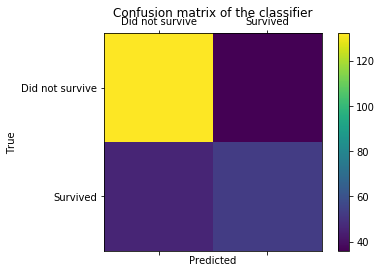

Accuracy: 0.6928838951310862 
Precision: 0.7415730337078652 
Recall: 0.7857142857142857 
F1 score: 0.7630057803468209


(0.6928838951310862,
 0.7415730337078652,
 0.7857142857142857,
 0.7630057803468209)

In [27]:
# Confusion Matrix
pred_y2 = np.argmax(pred_y, axis=1)

labels = ['Did not survive', 'Survived']
cm = sklearn.metrics.confusion_matrix(cross_y, pred_y2)

# Plotting
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

get_metrics(cm, True)

## Past results:

In [ ]:
# Past results
cm_22oct1 = [[120, 37],[ 49, 61]]
cm_22oct2 = [[131, 34],[49, 53]]

cms   = [cm_22oct1,  cm_22oct2]
dates = ['22 Oct 1', '22 Oct 2']

accuracy = [] # ratio of correctly predicted observation to the total observations
precision = [] # ratio of correctly predicted positive observations to the total predicted positive observations
recall = [] # ratio of correctly predicted positive observations to the all observations in actual class - yes
f1score = [] # weighted average of Precision and Recall

for cm in cms:
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]
    accuracy.append((TP+TN)/(TP+FP+FN+TN))
    precision.append(TP/(TP+FP))
    recall.append(TP/(TP+FN))
    f1score.append(2/((1/recall[-1])+(1/precision[-1])))
    
print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall, '\nF1 score:', f1score)

# Plot curves TODO